# Загрузка данных

Проект представляет собой исследование по суммаризации отзывов с сайта banki.ru. Как и в реальной бизнес-задаче у нас не будет таргетных суммаризаций. Идея попробовать что-то придумать, чтобы обойтись без них. Такая постановка задачи накладывает определенные сложности на определение качества подхода. 

Для примера возьмем данные по страхованию в сбербанке(так как у них больше отзывов).

Выгружаем данные, достаем нужную нам информацию и складываем в df.

In [253]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from tqdm import tqdm

base_url = 'https://banki.ru/'
companies = {
    'СБСЖ': {
        'pages': 160,  
        'url': 'insurance/responses/company/sberbankstrahovaniezhizni/',
    }, # СБСЖ 
    'СБС': {
        'pages': 197,
        'url': 'insurance/responses/company/sberbankstrahovanie/',
    }, # СБС 
}

page_url = '?page='

df = pd.DataFrame(columns=[
    'Компания', 'url жалобы', 'Заголовок', 'Статус', 'Текст', 'Время', 'Оценка', 'Оценка выплат',
])

for company in companies.keys():
    print(company)

    company_url = companies[company]['url']
    r = requests.get(base_url + company_url)
    soup = BeautifulSoup(r.text)

    pages = companies[company]['pages']

    for page in tqdm(range(1, pages + 1)):
        time.sleep(1)

        for article in soup.findAll('article'):
            href = article.find('a', {'data-test': 'responses-header'}).get('href')
            
            header = article.find('a', {'data-test': 'responses-header'}).text

            text = article.find('div', class_='responses__item__message markup-inside-small markup-inside-small--bullet').get_text(strip=True, separator=' ')
            time_ = article.find('time', {'data-test': 'responses-datetime'}).get('datetime')
            
            try:
                rating = article.find('span', {'data-test': 'responses-rating-grade'}).text.strip()
            except:
                rating = None
            try:
                rating_payouts = article.find('strong', {'class': 'font-size-medium'}).text.strip()
            except:
                rating_payouts = None
            try:
                rating_status = article.find('span', {'data-test': 'responses-status'}).text.strip()
            except:
                rating_status = None

            row = [company, base_url+href[1:], header, rating_status, text, time_, rating, rating_payouts]

            df.loc[len(df)] = row

        # Взятие следующей страницы
        try:
            if page <= pages:
                r = requests.get(base_url + company_url + page_url + str(page))
                soup = BeautifulSoup(r.text, features='lxml')
        except:
            pass

print(len(df))


C:\Users\aleksandr.egorov\.pyenv\pyenv-win\versions\3.10.11\lib\tokenize.py:527: RuntimeWarning: coroutine 'main' was never awaited
  pseudomatch = _compile(PseudoToken).match(line, pos)
C:\Users\aleksandr.egorov\.pyenv\pyenv-win\versions\3.10.11\lib\tokenize.py:527: RuntimeWarning: coroutine 'generate_answer' was never awaited
  pseudomatch = _compile(PseudoToken).match(line, pos)


СБСЖ


100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [04:21<00:00,  1.64s/it]


СБС


100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [05:10<00:00,  1.58s/it]

8925


In [349]:
df = df.drop_duplicates(subset=["Текст"]).reset_index(drop=True)

In [351]:
df.to_csv("sber_insurance.csv", index=False, header=True, encoding='utf-8')

In [1]:
import pandas as pd

df = pd.read_csv("sber_insurance.csv")

In [2]:
len(df["Текст"].unique())

8874

In [3]:
def clean_text(text):
    return " ".join(text.replace(u'\xa0', '').split())


df["Текст"] = df["Текст"].apply(clean_text)

In [55]:
df.iloc[:5,:]

,Компания,url жалобы,Заголовок,Статус,Текст,Время,Оценка,Оценка выплат
0,СБСЖ,https://banki.ru/insurance/responses/company/r...,Возврат страховой премии,Проверяется,ООО «Сбербанк страхование жизни» 13.12.2024 г....,2024-12-23 19:39:40,2.0,NaN
1,СБСЖ,https://banki.ru/insurance/responses/company/r...,Отвратительное обслуживание,Проверяется,"Мало того, что выплаты копеечные, так ещё не х...",2024-12-23 18:44:01,1.0,NaN
2,СБСЖ,https://banki.ru/insurance/responses/company/r...,Выплата,Проверяется,"Хотелось поделиться мнением о сберстраховании,...",2024-12-23 18:09:52,5.0,5.0
3,СБСЖ,https://banki.ru/insurance/responses/company/r...,Семейный актив сплошной обман,Проверяется,"К сожалению, я тоже стала жертвой обмана по ст...",2024-12-23 10:34:17,1.0,NaN
4,СБСЖ,https://banki.ru/insurance/responses/company/r...,"В ООО ,,Сбер страхование жизни,, рассказывают ...",Проверяется,Уважаемые клиенты Сбербанка! Не верьте когда в...,2024-12-23 09:43:44,1.0,NaN


Данные содержат следующие поля:

1) Компания
2) url жалобы(отзыва)
3) Заголовок
4) Статус
5) Текст
6) Время
7) Оценка
8) Оценка выплат

Мы будем работать только с колонкой Текст, которая представляет из себя тело отзыва.

Суммаризаторы делятся на экстрактивные и абстрактивные. 

Экстрактивная суммаризация заключается в извлечении из исходного текста наиболее «значимых» информационных блоков. В качестве блока могут выступать отдельные абзацы, предложения или ключевые слова. Ранжируя эти блоки по степени важности и выбирая ранее заданное их число, формируют итоговое резюме текста.

Абстрактивная суммаризация заключается в генерации краткого содержания с порождением нового текста, содержательно обобщающего первичный документ. Основная идея данного подхода состоит в том, что модель способна генерировать абсолютно уникальное резюме, которое может содержать слова, отсутствующие в исходном тексте. Вывод модели представляет собой пересказ текста, который более близок к ручному составлению краткого содержания текста людьми.

Рассмотрим оба эти подхода. Экстрактивные методы будем рассматривать с использованием библиотеки sumy, абстрактивные - transformers

# Экстрактивные методы

Отзыв, который возьмем для рассмотрения работы разных алгоритмов приведен ниже. Рассмотрение алгоритма на конкретном отзыве не говорит о его работе в целом. Но у нас нет эффективного способа посчитать метрику качества, так как нет таргетных суммаризаций. Посмотрим алгоритмы на частностях как элемент разведывательного анализа данных и просто познакомимся с ними:

In [19]:
df["Текст"][3]

'К сожалению, я тоже стала жертвой обмана по страховому продукту "Семейный актив". Все как у большинства обманутых. Менеджером СберПремьера был расхвален новый на тот момент продукт, с более высокой доходностью, чем от % по вкладам. В 2019году на меня было оформлено 2 полиса на суммы в 400тыс р и 300тыс с разницей в полгода. При заключении договора говорилось, что это своего рода копилочка, и что при наступлении сложных жизненных ситуация страховая сама будет делать взносы. Что срок договора при заключении чисто формальный, его можно поменять, но то что на этом теряется, то что ты внес умолчали. В итоге выяснилось позднее в 2020году, что надо ежегодно вносить изначально вложенный платеж, а именно 300 и 400 тыс по двум полисам. Естественно, такой возможности не было, тк на тот момент я находилась в декретном отпуске. Один полис был расторгнут страховой за невнесенные взносы в сумме 300тыс, в результате чего мои ранее внесенные 300тыс утекли в Сбербанк Страхование, по второму полису была

1) Latent Semantic Analysis

Саммари представляет из себя заданное количество предложений из исходного отзыва, которые выбраны как наиболее значимые.

Начиная с этого метода и везде далее при определении наиболее значимых предложений будем убирать из рассмотрения стоп-слова русского языка, которые берем из nltk

Все эти алгоритмы очень быстрые, поэтому сравнение их производительности не производится.

Алгоритм:
1) Получаем словарь уникальных слов (можно убрать стоп-слова по желанию)
2) Строим матрицу количества вхождений слов в предложения, где i, j элемент, это вхождение слова i в предложение j
3) Считаем Maximum tf normalization (https://nlp.stanford.edu/IR-book/html/htmledition/maximum-tf-normalization-1.html), моделируя таким образом важность слова в предложении.
4) Считаем сингулярное разложение от матрицы Maximum tf normalization с рангом k, где k = количество предложений
5) Считаем ранг каждого предложения в новой низкоранговой аппроксимации(взвешиваем столбцы матрицы V на собственные значения)
6) Берем n предложений с наибольшим рангом, это и будет краткое содержание(суммаризация)


In [4]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("russian"))

text = df["Текст"][3]
parser = PlaintextParser.from_string(text, Tokenizer("russian"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aleksandr.egorov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [355]:
from sumy.summarizers.lsa import LsaSummarizer

summarizer = LsaSummarizer()
summarizer.stop_words = stop_words
summary = summarizer(parser.document, 3)

In [356]:
summary

(<Sentence: При заключении договора говорилось, что это своего рода копилочка, и что при наступлении сложных жизненных ситуация страховая сама будет делать взносы.>,
 <Sentence: Один полис был расторгнут страховой за невнесенные взносы в сумме 300тыс, в результате чего мои ранее внесенные 300тыс утекли в Сбербанк Страхование, по второму полису была уменьшена сумма взносов на 25тыс, по которому был сделан платеж.>,
 <Sentence: Далее менеджер СберПремьер в 2021г сказала, что можно перевести его в статус оплачен и дождаться когда закончится договор, чтобы забрать свои внесенные денежные средства.>)

**Второе предложение по сути выражает основную претензию человека: потеря денег с указанием конкретных сумм. Но в идеальном кратком содержании скорее всего также было бы название продукта, так как непонятно о чем идет речь**

Подробный расчет

In [357]:
dictionary = summarizer._create_dictionary(parser.document)
dictionary

{'взносов': 0,
 'полиса': 1,
 'сказала': 2,
 'говорилось': 3,
 'личном': 4,
 'получил': 5,
 'стараются': 6,
 'соглашении': 7,
 'обесценились': 8,
 'количество': 9,
 'расторгнут': 10,
 'умолчали': 11,
 'внес': 12,
 'продукте': 13,
 'продукт': 14,
 'средств': 15,
 'страховой': 16,
 'годовых': 17,
 'обман': 18,
 'вообще': 19,
 'страховому': 20,
 'мало': 21,
 'скажешь': 22,
 'расхвален': 23,
 'это': 24,
 'р': 25,
 'внесенных': 26,
 'как-то': 27,
 'менеджер': 28,
 'заплатят': 29,
 'уменьшена': 30,
 'внесенные': 31,
 'ответила': 32,
 'возврату': 33,
 'платеж': 34,
 'именно': 35,
 'высокой': 36,
 'огромное': 37,
 'внимание': 38,
 'компания': 39,
 'слова': 40,
 'декретном': 41,
 'вестись': 42,
 'жизненных': 43,
 'сильно': 44,
 'трудовая': 45,
 'находилась': 46,
 'денежные': 47,
 'выкупные': 48,
 'писала': 49,
 'денежных': 50,
 'уходу': 51,
 'вернешь': 52,
 'отпуске': 53,
 'оплачен': 54,
 'рублей': 55,
 'перевести': 56,
 'свои': 57,
 'инфляцией': 58,
 'находились': 59,
 'свое': 60,
 'сложных': 

In [358]:
matrix = summarizer._create_matrix(parser.document, dictionary)

matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [359]:
matrix = summarizer._compute_term_frequency(matrix)

In [360]:
matrix

array([[0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4],
       [0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4],
       [0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4],
       ...,
       [0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4],
       [0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4],
       [0.4, 0.4, 0.4, ..., 0.4, 0.4, 0.4]])

In [361]:
from numpy.linalg import svd as singular_value_decomposition

u, sigma, v = singular_value_decomposition(matrix, full_matrices=False)

In [362]:
ranks = iter(summarizer._compute_ranks(sigma, v))

In [363]:
list(ranks)

[6.337191807101964,
 5.926212956011624,
 6.4031242374328805,
 6.2032249677083415,
 6.785278181474945,
 6.403124237432869,
 6.596969000988265,
 6.270566162636377,
 7.147027354082008,
 6.785278181474953,
 6.1351446600712,
 6.337191807101966,
 6.403124237432867,
 6.673829485385463,
 6.2032249677083415,
 6.2705661626363645,
 6.546754921333197,
 6.330086887239408,
 6.270566162636368,
 5.996665740225989,
 6.7852781814749115,
 6.6603303221387264,
 5.996665740225987]

### LexRankSummarizer

Алгоритм:
1) Представляем текст как граф, где узлы - предложения, а рёбра - косинусные расстояния, посчитанные в пространстве TF*IDF векторов.
2) Зануляем ребра со значением ниже трешхолда(по умолчанию 0.1)
3) Вычисляем ранг как центральность по собственному вектору

In [364]:
from sumy.summarizers.lex_rank import LexRankSummarizer

lex_rank_summarizer = LexRankSummarizer()
lex_rank_summarizer.stop_words = stop_words
lexrank_summary = lex_rank_summarizer(parser.document,sentences_count=3)

In [365]:
lexrank_summary

(<Sentence: Менеджером СберПремьера был расхвален новый на тот момент продукт, с более высокой доходностью, чем от % по вкладам.>,
 <Sentence: Что срок договора при заключении чисто формальный, его можно поменять, но то что на этом теряется, то что ты внес умолчали.>,
 <Sentence: Про то, что с этого я потеряю большую сумму не было сказано ни слова.>)

**Следующий алгоритм тоже выделил основную претензию - потерю денег, хоть и с помощью других предложений.**

In [366]:
sentences_words = [lex_rank_summarizer._to_words_set(s) for s in parser.document.sentences]
sentences_words

[['сожалению',
  'стала',
  'жертвой',
  'обмана',
  'страховому',
  'продукту',
  'семейный',
  'актив'],
 ['большинства', 'обманутых'],
 ['менеджером',
  'сберпремьера',
  'расхвален',
  'новый',
  'момент',
  'продукт',
  'высокой',
  'доходностью',
  'вкладам'],
 ['оформлено', 'полиса', 'суммы', 'р', 'разницей', 'полгода'],
 ['заключении',
  'договора',
  'говорилось',
  'это',
  'своего',
  'рода',
  'копилочка',
  'наступлении',
  'сложных',
  'жизненных',
  'ситуация',
  'страховая',
  'сама',
  'делать',
  'взносы'],
 ['срок',
  'договора',
  'заключении',
  'чисто',
  'формальный',
  'поменять',
  'теряется',
  'внес',
  'умолчали'],
 ['итоге',
  'выяснилось',
  'позднее',
  'ежегодно',
  'вносить',
  'изначально',
  'вложенный',
  'платеж',
  'именно',
  'тыс',
  'двум',
  'полисам'],
 ['естественно',
  'возможности',
  'тк',
  'момент',
  'находилась',
  'декретном',
  'отпуске'],
 ['полис',
  'расторгнут',
  'страховой',
  'невнесенные',
  'взносы',
  'сумме',
  'результате

In [367]:
tf_metrics = lex_rank_summarizer._compute_tf(sentences_words)
idf_metrics = lex_rank_summarizer._compute_idf(sentences_words)

In [368]:
matrix = lex_rank_summarizer._create_matrix(sentences_words, 0.1, tf_metrics, idf_metrics)
matrix

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.5       , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.33333333, 0.        , 0.        , 0.33333333,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.   

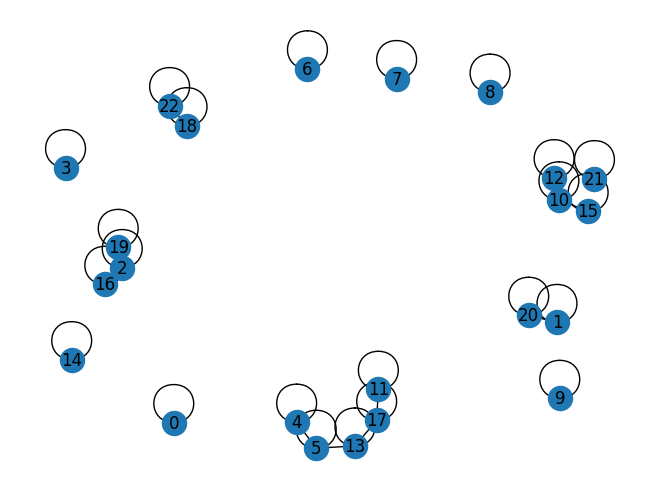

In [369]:
import networkx as nx

G = nx.from_numpy_array(matrix)

nx.draw(G, with_labels = True)

**Так как LexRunk графовый алгоритм, то можно посмотреть какие предложения он связывает в кластеры**

In [30]:
print(parser.document.sentences[19])
print(parser.document.sentences[2])
print(parser.document.sentences[16])


Отличный продукт, ничего не скажешь.
Менеджером СберПремьера был расхвален новый на тот момент продукт, с более высокой доходностью, чем от % по вкладам.
Писала уже по 2-м полисам, начитавшись отзывов об обманном продукте "Семейный актив", что огромное количество людей также как и я находились в полном неведении и что им также менеджером СберПремьера был расхвален данный продукт, что никакой информации о потерях денежных средств при изменении условий не было.


**Это похоже кластер, где есть положительно окрашенные слова хвалит, отличный, расхвален. Но здесь они идут в саркастической форме**

In [29]:
print(parser.document.sentences[4])
print(parser.document.sentences[5])
print(parser.document.sentences[13])
print(parser.document.sentences[17])
print(parser.document.sentences[11])

При заключении договора говорилось, что это своего рода копилочка, и что при наступлении сложных жизненных ситуация страховая сама будет делать взносы.
Что срок договора при заключении чисто формальный, его можно поменять, но то что на этом теряется, то что ты внес умолчали.
В итоге подошел срок договора и спустя 5 лет я узнаю, что мало того, что деньги сильно обесценились в связи с инфляцией, так еще и к возврату мне подлежит 157тыс руб, вместо внесенных 425тыс, за то что срок договора был изменен с 16 лет на 5, а затем полис был переведен в статус оплачен, тк на тот момент меня сократили и я являлась безработной.
В итоге вместо %, которые я вижу в личном кабинете, за 5 лет 87тыс рублей с суммы в 425тыс, это 5% годовых, это вообще ни о чем, уже обман только на этом, так в итоге и их не заплатят, тк были внесены изменения.
В доп соглашении были прописаны выкупные суммы, на которые я обратила внимание.


**Это кластер с подробностями и условиями договора**

In [371]:
scores = lex_rank_summarizer.power_method(matrix, 0.1)
scores

array([0.04347826, 0.04347826, 0.05797101, 0.04347826, 0.03623188,
       0.05072464, 0.04347826, 0.04347826, 0.04347826, 0.04347826,
       0.05797101, 0.03623188, 0.03623188, 0.04347826, 0.04347826,
       0.03623188, 0.03623188, 0.05072464, 0.04347826, 0.03623188,
       0.04347826, 0.04347826, 0.04347826])

### LuhnSummarizer

Алгоритм:
1) Находим частоту всех слов в тексте. 

2) В итоговом резюме сохраняются предложения, которые содержат больше высокочастотных слов.

In [372]:
from sumy.summarizers.luhn import LuhnSummarizer


In [373]:
lunh_summarizer = LuhnSummarizer()
lunh_summarizer.stop_words = stop_words
lunh_summary = lunh_summarizer(parser.document,sentences_count=3)

In [374]:
lunh_summary

(<Sentence: В итоге подошел срок договора и спустя 5 лет я узнаю, что мало того, что деньги сильно обесценились в связи с инфляцией, так еще и к возврату мне подлежит 157тыс руб, вместо внесенных 425тыс, за то что срок договора был изменен с 16 лет на 5, а затем полис был переведен в статус оплачен, тк на тот момент меня сократили и я являлась безработной.>,
 <Sentence: Писала уже по 2-м полисам, начитавшись отзывов об обманном продукте "Семейный актив", что огромное количество людей также как и я находились в полном неведении и что им также менеджером СберПремьера был расхвален данный продукт, что никакой информации о потерях денежных средств при изменении условий не было.>,
 <Sentence: В итоге вместо %, которые я вижу в личном кабинете, за 5 лет 87тыс рублей с суммы в 425тыс, это 5% годовых, это вообще ни о чем, уже обман только на этом, так в итоге и их не заплатят, тк были внесены изменения.>)

**Саммари впервые содержит не только проблему, но и указание на продукт**

In [375]:
significant_words = lunh_summarizer._get_significant_words(parser.document.words)
significant_words

('договора',
 'это',
 'итоге',
 'тк',
 'лет',
 'момент',
 'продукт',
 'суммы',
 'срок',
 'свое',
 'семейный',
 'актив',
 'обманутых',
 'менеджером',
 'сберпремьера',
 'расхвален',
 'заключении',
 'взносы',
 'ежегодно',
 'платеж',
 'полисам',
 'полис',
 'внесенные',
 'сбербанк',
 'страхование',
 'менеджер',
 'статус',
 'оплачен',
 'потеряю',
 'сумму',
 'которые',
 'вместо',
 'вернуть',
 'также')

### TextRankSummarizer

Алгоритм:
1) Создаем матрицу, где элемент i,j соответствует сходству предложений i и j, где сходство вычисляется как количество общих слов между ними, деленное
на сумму логарифмов их длин. 
2) Проводится нормализация матрицы по столбцам
3) В качестве меры связи используется мера Жаккара по совпадающим словам в предложениях
4) Выбираются n предложений с максимальным рангом


In [376]:
from sumy.summarizers.text_rank import TextRankSummarizer

summarizer = TextRankSummarizer()
summarizer.stop_words = stop_words
summary = summarizer(parser.document, 3)

In [377]:
summary

(<Sentence: В итоге подошел срок договора и спустя 5 лет я узнаю, что мало того, что деньги сильно обесценились в связи с инфляцией, так еще и к возврату мне подлежит 157тыс руб, вместо внесенных 425тыс, за то что срок договора был изменен с 16 лет на 5, а затем полис был переведен в статус оплачен, тк на тот момент меня сократили и я являлась безработной.>,
 <Sentence: Писала уже по 2-м полисам, начитавшись отзывов об обманном продукте "Семейный актив", что огромное количество людей также как и я находились в полном неведении и что им также менеджером СберПремьера был расхвален данный продукт, что никакой информации о потерях денежных средств при изменении условий не было.>,
 <Sentence: В итоге вместо %, которые я вижу в личном кабинете, за 5 лет 87тыс рублей с суммы в 425тыс, это 5% годовых, это вообще ни о чем, уже обман только на этом, так в итоге и их не заплатят, тк были внесены изменения.>)

**Результат совпадает с LuhnSummarizer, дальше сравним насколько вообще статистически алгоритмы часто выдают одинаковый результат**

In [378]:
matrix = summarizer._create_matrix(parser.document)
matrix

array([[0.71953327, 0.00652174, 0.00652174, 0.00652174, 0.00652174,
        0.00652174, 0.00652174, 0.00652174, 0.00652174, 0.00652174,
        0.00652174, 0.00652174, 0.00652174, 0.00652174, 0.00652174,
        0.00652174, 0.14351017, 0.00652174, 0.00652174, 0.00652174,
        0.00652174, 0.00652174, 0.00652174],
       [0.00652174, 0.71262196, 0.00652174, 0.00652174, 0.00652174,
        0.00652174, 0.00652174, 0.00652174, 0.00652174, 0.00652174,
        0.00652174, 0.00652174, 0.00652174, 0.00652174, 0.00652174,
        0.00652174, 0.00652174, 0.00652174, 0.00652174, 0.00652174,
        0.15042147, 0.00652174, 0.00652174],
       [0.00652174, 0.00652174, 0.50492737, 0.00652174, 0.00652174,
        0.00652174, 0.00652174, 0.06525929, 0.00652174, 0.00652174,
        0.00652174, 0.00652174, 0.00652174, 0.0494953 , 0.00652174,
        0.00652174, 0.1825671 , 0.00652174, 0.00652174, 0.08035961,
        0.00652174, 0.00652174, 0.00652174],
       [0.00652174, 0.00652174, 0.00652174, 0.670

In [379]:
ranks = summarizer.power_method(matrix, 1e-4)
ranks

array([0.03456058, 0.03374153, 0.04210872, 0.03389819, 0.04489844,
       0.03618703, 0.03949399, 0.03440248, 0.04794059, 0.03885263,
       0.03527928, 0.03639741, 0.0429888 , 0.08651605, 0.04347824,
       0.03904768, 0.06465727, 0.07039976, 0.03950036, 0.03021007,
       0.05542552, 0.03792509, 0.03208988])

### KLSummarizer

**Цель алгоритма — найти набор предложений, у которых распределение слов как можно больше похоже на исходный текст.**

**Алгоритм жадно добавляет предложения в текст, пока уменьшается относительная энтропия**

In [380]:
from sumy.summarizers.kl import KLSummarizer

summarizer = KLSummarizer()
summarizer.stop_words = stop_words
summary = summarizer(parser.document, 3)

In [381]:
summary

(<Sentence: При заключении договора говорилось, что это своего рода копилочка, и что при наступлении сложных жизненных ситуация страховая сама будет делать взносы.>,
 <Sentence: В итоге подошел срок договора и спустя 5 лет я узнаю, что мало того, что деньги сильно обесценились в связи с инфляцией, так еще и к возврату мне подлежит 157тыс руб, вместо внесенных 425тыс, за то что срок договора был изменен с 16 лет на 5, а затем полис был переведен в статус оплачен, тк на тот момент меня сократили и я являлась безработной.>,
 <Sentence: В итоге вместо %, которые я вижу в личном кабинете, за 5 лет 87тыс рублей с суммы в 425тыс, это 5% годовых, это вообще ни о чем, уже обман только на этом, так в итоге и их не заплатят, тк были внесены изменения.>)

**Тоже достаточно похоже на предыдущие, хотя сам алгоритм совсем другой - до этого были метрики на графах близости предложений, svd, а здесь - используется информация о близости распределений слов**

### EdmundsonSummarizer

Алгоритм сортирует предложения по вхождению трех типов слов: bonus_words(необходимые слова), null_words(нейтральные слова), stigma_words(нежелательные слова). Все эти слова эвристические и их необходимо задать

In [382]:
from sumy.summarizers.edmundson import EdmundsonSummarizer

summarizer = EdmundsonSummarizer()
summarizer.bonus_words = ( "нельзя", "обман","благодарность", "терять")
summarizer.null_words = ("страхование", "случай","деньги","сумма", "писать", "поделиться")
summarizer.stigma_words = ("говорят", "состояние", "БОЛЬЮ", "своей")
summary = summarizer(parser.document, 4)

In [383]:
summary

(<Sentence: К сожалению, я тоже стала жертвой обмана по страховому продукту "Семейный актив".>,
 <Sentence: Все как у большинства обманутых.>,
 <Sentence: В итоге вместо %, которые я вижу в личном кабинете, за 5 лет 87тыс рублей с суммы в 425тыс, это 5% годовых, это вообще ни о чем, уже обман только на этом, так в итоге и их не заплатят, тк были внесены изменения.>,
 <Sentence: Никогда не вернешь даже свое без потерь.>)

**Алгоритм сильнее отличается от остальных. Дело в том, что он использует слова-маркеры, которые мы задаем. С одной стороный это минус, так как взять эти слова можно только из экспертной оценки, но с другой стороны этот алгоритм самый интерпретируемый и кастомизированный под бизнес.**

**Далее сравним насколько статистически алгоритмы генерят похожие результаты - мерой похожести будем брать jaccard_similarity,
саммари генерим из 4х предложений каждое и прогоняем их на всех доступных нам отзывах(порядка 9к)**

In [5]:
def jaccard_similarity(summary1, summary2):
    intersection = len(list(set(summary1).intersection(summary2)))
    union = (len(set(summary1)) + len(set(summary2))) - intersection
    return float(intersection) / union

In [6]:
from tqdm import tqdm
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.edmundson import EdmundsonSummarizer

lsa_summarizer = LsaSummarizer()
lsa_summarizer.stop_words = stop_words

lex_rank_summarizer = LexRankSummarizer()
lex_rank_summarizer.stop_words = stop_words

lunh_summarizer = LuhnSummarizer()
lunh_summarizer.stop_words = stop_words

textrank_summarizer = TextRankSummarizer()
textrank_summarizer.stop_words = stop_words

kl_summarizer = KLSummarizer()
kl_summarizer.stop_words = stop_words

edmundson_summarizer = EdmundsonSummarizer()
edmundson_summarizer.bonus_words = ( "нельзя", "обман","благодарность", "терять")
edmundson_summarizer.null_words = ("страхование", "случай","деньги","сумма", "писать", "поделиться")
edmundson_summarizer.stigma_words = ("говорят", "состояние")

df["KL"] = pd.NA
df["Edmundson"] = pd.NA
df["TextRank"] = pd.NA
df["Luhn"] = pd.NA
df["LexRank"] = pd.NA
df["Lsa"] = pd.NA
for i in tqdm(range(len(df["Текст"]))):
    parser = PlaintextParser.from_string(df["Текст"][i], Tokenizer("russian"))
    df.at[i, "Lsa"] = lsa_summarizer(parser.document, 4)
    df.at[i, "LexRank"] = lex_rank_summarizer(parser.document, 4)
    df.at[i, "Luhn"] = lunh_summarizer(parser.document, 4) 
    df.at[i, "TextRank"] = textrank_summarizer(parser.document, 4) 
    df.at[i, "KL"] = kl_summarizer(parser.document, 4)
    df.at[i, "Edmundson"] = edmundson_summarizer(parser.document, 4) 

100%|██████████████████████████████████████████████████████████████████████████████| 8874/8874 [03:26<00:00, 42.91it/s]


In [387]:
df_corr = pd.DataFrame(1, columns=df.iloc[:, -6:].columns, index=df.iloc[:, -6:].columns)

In [388]:
from itertools import combinations
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
comb = list(combinations(df.iloc[:, -6:].columns, 2))

for c in tqdm(comb):
    temp = []
    for i in range(len(df["Текст"])):
        temp.append(jaccard_similarity(df[c[0]][i], df[c[1]][i]))
    mean_jaccard = np.mean(temp)
    df_corr.at[c] = mean_jaccard
    df_corr.at[c[::-1]] = mean_jaccard

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 16.05it/s]


In [389]:
df_corr

,KL,Edmundson,TextRank,Luhn,LexRank,Lsa
KL,1.000000,0.452116,0.463199,0.470483,0.450659,0.441035
Edmundson,0.452116,1.000000,0.439342,0.497776,0.569338,0.440624
TextRank,0.463199,0.439342,1.000000,0.571766,0.503645,0.608572
Luhn,0.470483,0.497776,0.571766,1.000000,0.646482,0.517950
LexRank,0.450659,0.569338,0.503645,0.646482,1.000000,0.477169
Lsa,0.441035,0.440624,0.608572,0.517950,0.477169,1.000000


**Самыми "похожими" оказались LexRank и Luhn, больше всего отличаются от остальных KL и Edmundson, что неудивительно, так как они имеют под собой совсем другие идеи**

In [33]:
import pprint

pprint.pp(df.iloc[:10, -6:].T.to_dict())

{0: {'Edmundson': '(<Sentence: ООО «Сбербанк страхование жизни» 13.12.2024 г. '
                  'получило мое заявление об отказе от договора страхования в '
                  'период охлаждения (составляет 30 календарных дней), однако '
                  'деньги до сих пор не поступили на мой счет указанный в '
                  'заявлении.>, <Sentence: С чем связана задержка возврата, '
                  'ведь согласно действующему законодательству возврат денег '
                  'должен быть осуществлен в течении семи рабочих дней.>)',
     'TextRank': '(<Sentence: ООО «Сбербанк страхование жизни» 13.12.2024 г. '
                 'получило мое заявление об отказе от договора страхования в '
                 'период охлаждения (составляет 30 календарных дней), однако '
                 'деньги до сих пор не поступили на мой счет указанный в '
                 'заявлении.>, <Sentence: С чем связана задержка возврата, '
                 'ведь согласно действующему законодательству 

**Вывод: экстрактивные методы просты в реализации(даже в исходниках нетрудно разобраться), интерпретируемы, быстро работают и не галлюцинируют, так как просто выделяют топ самых важных предложений в тексте). В целом все работают достаточно адекватно и не выдают совсем ерунду.**

**Главный минус - саммари содержит ТОЛЬКО предложения исходного отзыва и не создают на их основе ничего нового. Методы вполне рабочие и могли бы подойти для задач, где важна интерпретируемость и отсутствие голлюцинаций(где цена ошибки высока)**

# Абстрактивные методы

**Для абстрактивных методов нужны таргетные саммари. Некоторые исследователи предлагают брать, например, первые 3 предложения как таргет. Идея в том, что человек в начале выскажет что-то главное. Но это далеко не всегда так, поэтому возьмем в качестве саммари результаты экстрактивных алгоритмов как начальное приближение, мы видели, что они в целом генерят что-то адекватное. Из какого алгоритма брать таргет будем решать для каждого отзыва случайным образом.**

In [9]:
import random

def algo_result_to_str(df):
    df["target"] = pd.NA
    algos = list(df.iloc[:, -6:-1].columns)
    for j in range(df.shape[0]):
        target = []
        algo = random.choice(algos)
        for i in df[algo][j]:
            target.append(str(i))
        df.at[j, "target"] =  " ".join(target)
    return df

full_df = algo_result_to_str(df)

**Разделим полученные таким образом тексты и их таргет-саммари на обучение, валидацию и тест.**

In [206]:
from sklearn.model_selection import train_test_split
import pyarrow as pa
from datasets import Dataset

train, test = train_test_split(full_df[["Текст", "target"]], test_size=0.2)
test, val = train_test_split(test, test_size=0.8)

train_data, valid_data, test_data = Dataset(pa.Table.from_pandas(train, preserve_index=False)),  Dataset(pa.Table.from_pandas(val, preserve_index=False)),  Dataset(pa.Table.from_pandas(test, preserve_index=False))

**В качестве модели суммаризации и соответствующего ей токенизатора для fine tune возьмем sarahai/ruT5-base-summarizer. Из коробки она работает очень плохо на наших данных и неспособна выдать что-то адекватное**

In [207]:
test_data['Текст'][11]

'Добрый день. Находясь в декретном отпуске, у меня сложилась трудная финансовая ситуация, я решила расторгнуть договор сберегательного страхования жизни и здоровья 7000075944, заключенный в феврале 2016 года в ПАО СБЕРБАНК г.Стрежевого Томской области. 14.12.2018 года я подала заявку на расторжение договора. 18.12.2018 года мне пришло смс уведомление о том, что документы приняты в работу и переданы в страховую компанию. 18.01.2019 мне на мою электронную почту пришло уведомление от страховой компании, что документы на расторжение программы страхования № 7000075944 поступили в страховую компанию и переданы на выплату. По условиям сберегательного страхования, договор может быть расторгнут только на 31 день от даты уведомления оформления заявления на расторжение договора.Через 31 день естественно ни ответа, ни привета. Звонила постоянно на горячую линию страховой компании по номеру: 88005555595, где сотрудники постоянно отвечают, что документы переданы в бухгалтерию и на днях мне должны вы

In [160]:

text = test_data['Текст'][11]

model_name = "sarahai/ruT5-base-summarizer"  
tokenizer = T5Tokenizer.from_pretrained(model_name)
trained_model = T5ForConditionalGeneration.from_pretrained(model_name)

input_ids = tokenizer(text, return_tensors="pt").input_ids
 
generated_ids = trained_model.generate(input_ids, do_sample=True, 
    max_length=100, 
    top_k=5, 
    temperature=0.5,
    num_beams=5,
)

summary = tokenizer.decode(generated_ids.squeeze(), skip_special_tokens=True)
if (summary[-1] != '.') & ('.' in  summary):
    print(".".join(summary.split('.')[:-1]))
else:
    print(summary)

loading file spiece.model from cache at C:\Users\aleksandr.egorov\.cache\huggingface\hub\models--sarahai--ruT5-base-summarizer\snapshots\8d8493f1014d57ae0dfa6c81402036456e6b94b4\spiece.model
loading file added_tokens.json from cache at C:\Users\aleksandr.egorov\.cache\huggingface\hub\models--sarahai--ruT5-base-summarizer\snapshots\8d8493f1014d57ae0dfa6c81402036456e6b94b4\added_tokens.json
loading file special_tokens_map.json from cache at C:\Users\aleksandr.egorov\.cache\huggingface\hub\models--sarahai--ruT5-base-summarizer\snapshots\8d8493f1014d57ae0dfa6c81402036456e6b94b4\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\aleksandr.egorov\.cache\huggingface\hub\models--sarahai--ruT5-base-summarizer\snapshots\8d8493f1014d57ae0dfa6c81402036456e6b94b4\tokenizer_config.json
loading file tokenizer.json from cache at None
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
loading configuration

Я нахожусь в декретном отпуске, нахожусь в декретном отпуске и решила расторгнуть договор сберегательного страхования жизни и здоровья 7000075944, заключенный в 2016 году в ПАО СБЕРБАНК г.Стрежевого Томской области.


**Модель из коробки просто продублировала слова**

In [205]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "sarahai/ruT5-base-summarizer"  
tokenizer = T5Tokenizer.from_pretrained(model_name)

max_input_length = 128
max_target_length = 64

def preprocess_examples(df):
  # encode the documents
  inputs = df['Текст']
  summaries = df['target']
  model_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length", truncation=True)

  # encode the summaries
  labels = tokenizer(summaries, max_length=max_target_length, padding="max_length", truncation=True).input_ids

  # important: we need to replace the index of the padding tokens by -100
  # such that they are not taken into account by the CrossEntropyLoss
  labels_with_ignore_index = []
  for labels_example in labels:
    labels_example = [label if label != 0 else -100 for label in labels_example]
    labels_with_ignore_index.append(labels_example)
  
  model_inputs["labels"] = labels_with_ignore_index

  return model_inputs

loading file spiece.model from cache at C:\Users\aleksandr.egorov\.cache\huggingface\hub\models--sarahai--ruT5-base-summarizer\snapshots\8d8493f1014d57ae0dfa6c81402036456e6b94b4\spiece.model
loading file added_tokens.json from cache at C:\Users\aleksandr.egorov\.cache\huggingface\hub\models--sarahai--ruT5-base-summarizer\snapshots\8d8493f1014d57ae0dfa6c81402036456e6b94b4\added_tokens.json
loading file special_tokens_map.json from cache at C:\Users\aleksandr.egorov\.cache\huggingface\hub\models--sarahai--ruT5-base-summarizer\snapshots\8d8493f1014d57ae0dfa6c81402036456e6b94b4\special_tokens_map.json
loading file tokenizer_config.json from cache at C:\Users\aleksandr.egorov\.cache\huggingface\hub\models--sarahai--ruT5-base-summarizer\snapshots\8d8493f1014d57ae0dfa6c81402036456e6b94b4\tokenizer_config.json
loading file tokenizer.json from cache at None
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [162]:
encoded_train_ds = train_data.map(preprocess_examples, batched=True, remove_columns=train_data.column_names)
encoded_val_ds = valid_data.map(preprocess_examples, batched=True, remove_columns=valid_data.column_names)
encoded_test_ds = test_data.map(preprocess_examples, batched=True, remove_columns=test_data.column_names)
encoded_train_ds.set_format(type="torch")
encoded_val_ds.set_format(type="torch")
encoded_test_ds.set_format(type="torch")

Map:   0%|          | 0/7099 [00:00<?, ? examples/s]

Map:   0%|          | 0/1420 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

In [163]:
print("Number of training examples:", len(encoded_train_ds))
print("Number of validation examples:", len(encoded_val_ds))
print("Number of test examples:", len(encoded_test_ds))

Number of training examples: 7099
Number of validation examples: 1420
Number of test examples: 355


In [164]:
from torch.utils.data import DataLoader

def create_dataloaders(train_batch_size=8, eval_batch_size=8):
    train_dataloader = DataLoader(encoded_train_ds, shuffle=True, batch_size=train_batch_size)
    val_dataloader = DataLoader(encoded_val_ds, shuffle=False, batch_size=eval_batch_size)
    
    return train_dataloader, val_dataloader

In [165]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 2,
    "train_batch_size": 8, # Actual batch size will this x 8 (was 8 before but can cause OOM)
    "eval_batch_size": 8, # Actual batch size will this x 8 (was 32 before but can cause OOM)
    "seed": 42,
    "patience": 1, # early stopping
    "output_dir": "/content/",
}

**Обучение реализовано через Accelerator, что позволяет использовать распределенные вычисления при желании**

In [166]:
import torch
from transformers import T5ForConditionalGeneration, AdamW, set_seed
from accelerate import Accelerator
from tqdm.notebook import tqdm
import datasets
import transformers

def training_function():
    # Initialize accelerator
    accelerator = Accelerator()
    device = torch.device("cuda")
    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])
    model_name = "sarahai/ruT5-base-summarizer"  
    # Instantiate the model, let Accelerate handle the device placement.
    model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

    # Instantiate optimizer
    optimizer = AdamW(model.parameters(), lr=hyperparameters["learning_rate"])

    # Prepare everything
    train_dataloader, val_dataloader = create_dataloaders(
        train_batch_size=hyperparameters["train_batch_size"], eval_batch_size=hyperparameters["eval_batch_size"]
    )
    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(model, optimizer, 
                                                                             train_dataloader, val_dataloader)
    
    # Now we train the model
    epochs_no_improve = 0
    min_val_loss = float("inf")
    for epoch in range(hyperparameters["num_epochs"]):
        # We only enable the progress bar on the main process to avoid having 8 progress bars.
        progress_bar = tqdm(range(len(train_dataloader)), disable=not accelerator.is_main_process)
        progress_bar.set_description(f"Epoch: {epoch}")
        model.train()
        for batch in train_dataloader:
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)
            
            optimizer.step()
            optimizer.zero_grad()
            progress_bar.set_postfix({'loss': loss.item()})
            progress_bar.update(1)

        # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
        model.eval()
        validation_losses = []
        for batch in val_dataloader:
            with torch.no_grad():
                outputs = model(**batch)
            loss = outputs.loss

            # We gather the loss from the 8 TPU cores to have them all.
            validation_losses.append(accelerator.gather(loss[None]))

        # Compute average validation loss
        val_loss = torch.stack(validation_losses).sum().item() / len(validation_losses)
        # Use accelerator.print to print only on the main process.
        accelerator.print(f"epoch {epoch}: validation loss:", val_loss)
        if val_loss < min_val_loss:
          epochs_no_improve = 0
          min_val_loss = val_loss
          continue
        else:
          epochs_no_improve += 1
          # Check early stopping condition
          if epochs_no_improve == hyperparameters["patience"]:
            accelerator.print("Early stopping!")
            break

    # save trained model
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    # Use accelerator.save to save
    unwrapped_model.save_pretrained(hyperparameters["output_dir"], save_function=accelerator.save)

In [167]:
from accelerate import notebook_launcher

notebook_launcher(training_function, num_processes=1)

Launching training on one GPU.


loading configuration file config.json from cache at C:\Users\aleksandr.egorov\.cache\huggingface\hub\models--sarahai--ruT5-base-summarizer\snapshots\8d8493f1014d57ae0dfa6c81402036456e6b94b4\config.json
Model config T5Config {
  "_name_or_path": "ai-forever/ruT5-base",
  "_num_labels": 2,
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 2,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "earl

  0%|          | 0/888 [00:00<?, ?it/s]

epoch 0: validation loss: 0.5113125061720944


  0%|          | 0/888 [00:00<?, ?it/s]

Configuration saved in /content/config.json
Configuration saved in /content/generation_config.json


epoch 1: validation loss: 0.5009326720505618


Model weights saved in /content/model.safetensors


In [168]:

text = test_data['Текст'][11]

trained_model = T5ForConditionalGeneration.from_pretrained(hyperparameters["output_dir"])

input_ids = tokenizer(text, return_tensors="pt").input_ids
 
generated_ids = trained_model.generate(input_ids, do_sample=True, 
    max_length=100, 
    top_k=5, 
    temperature=0.5,
    num_beams=5,
)

summary = tokenizer.decode(generated_ids.squeeze(), skip_special_tokens=True)
if (summary[-1] != '.') & ('.' in  summary):
    print(".".join(summary.split('.')[:-1]))
else:
    print(summary)

loading configuration file /content/config.json
Model config T5Config {
  "_name_or_path": "sarahai/ruT5-base-summarizer",
  "_num_labels": 2,
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 2,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams"

Добрый день. Находясь в декретном отпуске, у меня сложилась трудная финансовая ситуация, я решила расторгнуть договор сберегательного страхования жизни и здоровья 7000075944, заключенный в феврале 2016 года в ПАО СБЕРБАНК г.Стрежевого Томской области. 14.12


**После небольшого файн тюнинга стало уже лучше, но модель имеет +- те же недостатки, она имеет низкую вариативность от исходных предложений, так как обучалась на выводах экстрактивных алгоритмов**

In [169]:
#pip install -U "huggingface_hub[cli]"

**Попробуем готовые модели без файн тюна. Вдруг ненадо что-то делать и уже есть готове решение, которое прекрасно работает**

**Рассмотрим мультиязычные модели mT5_multilingual_XLSum, utrobinmv/t5_summary_en_ru_zh_base_2048 и русскоязычную IlyaGusev/rubert_telegram_headlines.**

**Модели выбирались по поддержке русского языка, способности решать задачу суммаризации и лайкам на huggingface**

In [170]:
import re
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

WHITESPACE_HANDLER = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))

article_text=test_data['Текст'][11]
model_name = "csebuetnlp/mT5_multilingual_XLSum"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

input_ids = tokenizer(
    [WHITESPACE_HANDLER(article_text)],
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=1028
)["input_ids"]

output_ids = model.generate(
    input_ids=input_ids,
    max_length=1028,
    num_beams=4,
    top_k=5, 
    temperature=1,
    do_sample=True
)[0]

summary = tokenizer.decode(
    output_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=False
)

print(summary)

loading configuration file config.json from cache at C:\Users\aleksandr.egorov\.cache\huggingface\hub\models--csebuetnlp--mT5_multilingual_XLSum\snapshots\2437a524effdbadc327ced84595508f1e32025b3\config.json
Model config MT5Config {
  "_name_or_path": "csebuetnlp/mT5_multilingual_XLSum",
  "architectures": [
    "MT5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "length_penalty": 0.6,
  "max_length": 84,
  "model_type": "mt5",
  "no_repeat_ngram_size": 2,
  "num_beams": 4,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_wor

В интервью Русской службе Би-би-си корреспондент ВВС Украина Ольга Ившина рассказывает о том, почему она решила расторгнуть договор сберегательного страхования жизни і здоровья.


In [171]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

device = 'cuda' #or 'cpu' for translate on cpu

model_name = 'utrobinmv/t5_summary_en_ru_zh_base_2048'
model = T5ForConditionalGeneration.from_pretrained(model_name)
model.eval()
model.to(device)
tokenizer = T5Tokenizer.from_pretrained(model_name)

text = test_data['Текст'][11]
# text summary generate
prefix = 'summary: '
src_text = prefix + text
input_ids = tokenizer(src_text, return_tensors="pt")

generated_tokens = model.generate(**input_ids.to(device))

result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
print(result)

# text brief summary generate
prefix = 'summary brief: '
src_text = prefix + text
input_ids = tokenizer(src_text, return_tensors="pt")

generated_tokens = model.generate(**input_ids.to(device))

result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
print(result)

# text big summary generate
prefix = 'summary big: '
src_text = prefix + text
input_ids = tokenizer(src_text, return_tensors="pt")

generated_tokens = model.generate(**input_ids.to(device),     max_length=1028,
    num_beams=4,
    top_k=5, 
    temperature=1,
    do_sample=True)

result = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
print(result)


loading configuration file config.json from cache at C:\Users\aleksandr.egorov\.cache\huggingface\hub\models--utrobinmv--t5_summary_en_ru_zh_base_2048\snapshots\b15d6a01373b415ceba684286fbdcc3cbaa734fc\config.json
Model config T5Config {
  "_name_or_path": "/share/t5_summary_en_ru_zh_base_2048",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "tie_word_embeddings": false,
  "torch_dtype": "float32",
  "transformers_version": "4.46.2",


['У меня сложилась трудная финансовая ситуация, поэтому она решила расторгнуть договор сберегательного страхования жизни и здоровья']
['Женщина решила расторгнуть договор сберегательного страхования жизни и здоровья на 31 день']
['В 2018 году я подала заявку на расторжение договора сберегательного страхования жизни и здоровья No 70075944, который может быть расторгнут только на 31 день от даты уведомлений оформления заявления.']


In [172]:
from transformers import AutoTokenizer, EncoderDecoderModel

model_name = "IlyaGusev/rubert_telegram_headlines"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False, do_basic_tokenize=False, strip_accents=False)
model = EncoderDecoderModel.from_pretrained(model_name)

article_text = test_data['Текст'][11]

input_ids = tokenizer(
    [article_text],
    add_special_tokens=True,
    max_length=256,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
)["input_ids"]

output_ids = model.generate(
    input_ids=input_ids,
    max_length=64,
    no_repeat_ngram_size=3,
    num_beams=10,
    top_p=0.95,
    do_sample=True
)[0]

headline = tokenizer.decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
print(headline)

loading configuration file config.json from cache at C:\Users\aleksandr.egorov\.cache\huggingface\hub\models--IlyaGusev--rubert_telegram_headlines\snapshots\606eae9f1f6d2eb45da5ba16675486b9b0874ca0\config.json
Model config EncoderDecoderConfig {
  "_name_or_path": "IlyaGusev/rubert_telegram_headlines",
  "architectures": [
    "EncoderDecoderModel"
  ],
  "bos_token_id": 101,
  "decoder": {
    "_attn_implementation_autoset": false,
    "_name_or_path": "",
    "add_cross_attention": true,
    "architectures": null,
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 101,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": 101,
    "directionality": "bidi",
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 102,
    "exponential_decay_length_p

Оперативная информация по страхованию жизни, здоровья и здоровья томичей в декретном отпуске


**Из всех относительно адекватное сходу выдала только utrobinmv/t5_summary_en_ru_zh_base_2048. Но я крутил ее на других отзывах и результат неудовлетворительный для продакшн решения. Поэтому будем продолжать делать что-то свое.**

**Теперь попробуем все же добавить абстрактивность в нашу модель. Идея - возьмем мощную модель по типу мистраля. Используем ее как генератор таргетных саммари и дообучим нашу модель с этими таргетами.**

**Вопрос: почему не взять сразу мистраль и дообучить/использовать только ее?**

**Ответ: ниже будет показано, что мистраль может косячить при выдаче результата в зависимости от промта(например, в рандомный момент менять язык), а дообучить ее очень долго и требует много вычислительных ресурсов. Хотя это может быть хорошим решением при получении откуда-то правильных таргетов(например, при ручной разметке).**

In [88]:
from huggingface_hub import notebook_login
notebook_login()




**Мы попробуем объединить достоинства двух подходов экстрактивного и абстрактивного: менять на таргеты от мистраля будем только 900 примеров из обучающей выборки, а остальные оставим из экстрактивных методов. Выбирать примеры будем по размеру(900 самых больших) - я увидел эмперически, что мистраль плохо обобщает короткие отзывы - не хватает контекста, для них оставим старый подход. В день при обычном аккаунту на hf можно использовать не больше 1000 промтов**

**Реализуем все это асинхронно, количество подключений контролируем семафором**

In [12]:
import asyncio
from huggingface_hub import AsyncInferenceClient
client = AsyncInferenceClient()

longest_900 = sorted([(len(i.split()), idx) for idx, i in enumerate(train_data['Текст'])])[-900:]

async def generate_answer(prompt, semaphore):
    messages = [
        {
            "role": "user",
            "content": f"""Используй текст, чтобы выделить основную мысль. 
                        Текст:
                        {train_data['Текст'][prompt[1]]}
                        Question: Краткое изложение только на русском языке."""
        },
    ]
    async with semaphore:
    
        completion = await client.chat.completions.create(
            model="mistralai/Mixtral-8x7B-Instruct-v0.1", 
            messages=messages,
            max_tokens=150,
        )
        return (prompt[1], completion.choices[0].message.content)


tasks = []
semaphore = asyncio.Semaphore(value=100)
for prompt in longest_900:
    task = asyncio.create_task(generate_answer(prompt, semaphore))
    tasks.append(task)
results = await asyncio.gather(*tasks)




In [334]:
results[:10]

[(5357,
  ' Главная мысль текста состоит в жалобе на Сбербанк Страхование Жизни за невыполнение своих договорных обязательств. Пожилая женщина, страдающая неоперабельным раком лёгкого, заключила договор страхования жизни в СМАРТПОЛИС с помощью своего менеджера Сбербанка. Позже, она назначила своего племянника выгодоприобретателем. Когда болезнь прогре'),
 (5860,
  ' Главная мысль:\n\nКредитная карта Сбербанка автоматически включает страхование владельца карты и страхование от диагностирования опасных заболеваний без явного согласия клиента. Несмотря на отказ от дополнительной страховки при получении карты, была списана плата за страхование. Несмотря на закрытое отделение банка из-за локдауна, клиент не смог вовремя отменить страхование в течение '),
 (6197, ' 6 октября 2'),
 (104,
  ' 22 Марта 2024 года произошел страховой случай, связанный с автомобильным страхованием ОСАГО у компании с полисом HHH 02*****41. Клиент предоставил необходимые документы представителю страховой компании в 

**Получены полноценные абстрактивные суммаризации, добавим их в качестве таргетов**

In [ ]:
def change_values(example, idx):
    changed_examples = [i[0] for i in results]
    if idx in changed_examples:
         example['target'] = results[changed_examples.index(idx)][1]
    return example

In [263]:
train_data = train_data.map(change_values, with_indices=True)

Map:   0%|          | 0/7099 [00:00<?, ? examples/s]

**Для наглядности попробуем обучить модель на таргетах из мистраля и из экстрактивных алгоритмов в соотношении примерно 1 к 1. Более правильно было бы нагенерить всю таргетную выборку из мистраля, но для этого надо создавать много аккаунтов или покупать премиум на hg,чтобы обойти ограничение на количество обращений к инференсу, а на это нет времени**

In [290]:
import random
mistral = [i[1] for i in longest_900]
while len(mistral)< 2000:
    num = random.randint(0,7000)
    if num not in mistral:
        mistral.append(num)
small_dataset = train_data.select(mistral)

In [292]:
encoded_train_ds = small_dataset.map(preprocess_examples, batched=True, remove_columns=train_data.column_names)
encoded_val_ds = valid_data.map(preprocess_examples, batched=True, remove_columns=valid_data.column_names)
encoded_test_ds = test_data.map(preprocess_examples, batched=True, remove_columns=test_data.column_names)
encoded_train_ds.set_format(type="torch")
encoded_val_ds.set_format(type="torch")
encoded_test_ds.set_format(type="torch")

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1420 [00:00<?, ? examples/s]

Map:   0%|          | 0/355 [00:00<?, ? examples/s]

In [293]:
from torch.utils.data import DataLoader

def create_dataloaders(train_batch_size=8, eval_batch_size=8):
    train_dataloader = DataLoader(encoded_train_ds, shuffle=True, batch_size=train_batch_size)
    val_dataloader = DataLoader(encoded_val_ds, shuffle=False, batch_size=eval_batch_size)
    
    return train_dataloader, val_dataloader

In [308]:
hyperparameters = {
    "learning_rate": 0.0001,
    "num_epochs": 1,
    "train_batch_size": 8, # Actual batch size will this x 8 (was 8 before but can cause OOM)
    "eval_batch_size": 8, # Actual batch size will this x 8 (was 32 before but can cause OOM)
    "seed": 42,
    "patience": 2, # early stopping
    "output_dir": "/content_model/",
}

In [309]:
import torch
from transformers import T5ForConditionalGeneration, AdamW, set_seed
from accelerate import Accelerator
from tqdm.notebook import tqdm
import datasets
import transformers

def training_function():
    # Initialize accelerator
    accelerator = Accelerator()
    device = torch.device("cuda")
    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()
# 
    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])
    model_name = "sarahai/ruT5-base-summarizer"  
    # Instantiate the model, let Accelerate handle the device placement.
    model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

    # Instantiate optimizer
    optimizer = AdamW(model.parameters(), lr=hyperparameters["learning_rate"])

    # Prepare everything
    train_dataloader, val_dataloader = create_dataloaders(
        train_batch_size=hyperparameters["train_batch_size"], eval_batch_size=hyperparameters["eval_batch_size"]
    )
    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(model, optimizer, 
                                                                             train_dataloader, val_dataloader)
    
    # Now we train the model
    epochs_no_improve = 0
    min_val_loss = float("inf")
    for epoch in range(hyperparameters["num_epochs"]):
        progress_bar = tqdm(range(len(train_dataloader)), disable=not accelerator.is_main_process)
        progress_bar.set_description(f"Epoch: {epoch}")
        model.train()
        for batch in train_dataloader:
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)
            
            optimizer.step()
            optimizer.zero_grad()
            progress_bar.set_postfix({'loss': loss.item()})
            progress_bar.update(1)

        # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
        model.eval()
        validation_losses = []
        for batch in val_dataloader:
            with torch.no_grad():
                outputs = model(**batch)
            loss = outputs.loss

            validation_losses.append(accelerator.gather(loss[None]))

        # Compute average validation loss
        val_loss = torch.stack(validation_losses).sum().item() / len(validation_losses)
        # Use accelerator.print to print only on the main process.
        accelerator.print(f"epoch {epoch}: validation loss:", val_loss)
        if val_loss < min_val_loss:
          epochs_no_improve = 0
          min_val_loss = val_loss
          continue
        else:
          epochs_no_improve += 1
          # Check early stopping condition
          if epochs_no_improve == hyperparameters["patience"]:
            accelerator.print("Early stopping!")
            break

    # save trained model
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    # Use accelerator.save to save
    unwrapped_model.save_pretrained(hyperparameters["output_dir"], save_function=accelerator.save)

In [310]:
# train_data.save_to_disk("./train_data")
# valid_data.save_to_disk("./valid_data")
# test_data.save_to_disk("./test_data")

In [311]:
from accelerate import notebook_launcher

notebook_launcher(training_function, num_processes=1)

Launching training on one GPU.


loading configuration file config.json from cache at C:\Users\aleksandr.egorov\.cache\huggingface\hub\models--sarahai--ruT5-base-summarizer\snapshots\8d8493f1014d57ae0dfa6c81402036456e6b94b4\config.json
Model config T5Config {
  "_name_or_path": "ai-forever/ruT5-base",
  "_num_labels": 2,
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 2,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "earl

  0%|          | 0/250 [00:00<?, ?it/s]

Configuration saved in /content_model/config.json
Configuration saved in /content_model/generation_config.json


epoch 0: validation loss: 0.6206265567393785


Model weights saved in /content_model/model.safetensors


In [312]:
test_data['Текст'][0]

'Уже который год пользуюсь страхованием от Сбера. И этот год не исключение, на данный момент у меня действует полис N 01**************38_2DENTстоматология. Сейчас я лечу зубы, планирую возместить оплату за лечение по данному полису. В Сбере я уверенна, уже не однократно страховалась и получала выплаты. Так же из плюсов хочу отметить не только уверенность в своем выборе, но и простоту использования приложения «Сберстрахование», где можно не выходя из дома подать заявление на выплату. Все максимально понятно и доступно для простого человека. Однозначно рекомендую Сбер не только как банк, но и как страховую компанию.'

In [313]:
text = test_data['Текст'][0]

def get_summary(text):
    trained_model = T5ForConditionalGeneration.from_pretrained(hyperparameters["output_dir"])
    
    input_ids = tokenizer(text, return_tensors="pt").input_ids
     
    generated_ids = trained_model.generate(input_ids, do_sample=True, 
        max_length=150, 
        top_k=2, 
        temperature=0.9,
        num_beams=5,
    )
    
    summary = tokenizer.decode(generated_ids.squeeze(), skip_special_tokens=True)
    if (summary[-1] != '.') & ('.' in  summary):
        return ".".join(summary.split('.')[:-1])
    else:
        return summary


print(get_summary(text))

loading configuration file /content_model/config.json
Model config T5Config {
  "_name_or_path": "sarahai/ruT5-base-summarizer",
  "_num_labels": 2,
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 2,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_

Уже который год пользуюсь страхованием от Сбера. И этот год не исключение, на данный момент у меня действует полис N 01************38_2DENTстоматология. Сейчас я лечу зубы, планирую возместить оплату за лечение по данному полису. В Сбере я уверенна, уже не однократно страховалась и получала выплаты.


In [314]:
text = test_data['Текст'][111]
print(f"TEXT: {text}")

print(f"SUMMARY:{get_summary(text)}")


loading configuration file /content_model/config.json
Model config T5Config {
  "_name_or_path": "sarahai/ruT5-base-summarizer",
  "_num_labels": 2,
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 2,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_

TEXT: Я, , был обманут и введен в заблуждение сотрудниками Сбербанка. При посещении мною, офиса Сбербанк Премьер в городе Новороссийск 18.06.2019 года, имея максимальное доверие к Сбербанку и своему персональному Премьер менеджеру банка, я доверился словам менеджера, которая пригласила меня и разрекламировала новый продукт «Семейный актив. Менеджер совместно с руководителем отдела, уговорили меня доверять им, подписать не читая 30 страниц договора и открыть предлагаемый банком продукт «Семейный актив» ВМР1№000*****84 с годовым взносом 54999,02 рублей и окончанием договора 17.06.2047г. Уговаривая меня и подробно рассказывая о всех условиях «Семейный актив» сотрудник сбербанка уверяла а руководитель отдела подтверждала ее слова: что наиболее выгодно заключить соответствующий программе договор на срок более 25 лет, но уже через 5 лет я смогу вернуть все внесенные мною за 5 лет средства плюс накопленную возможно большую прибыль превышающую ставку по стандартным депозитам банка. После моего

In [332]:
text = test_data['Текст'][69]
print(f"TEXT: {text}")

print(f"SUMMARY:{get_summary(text)}")

loading configuration file /content_model/config.json
Model config T5Config {
  "_name_or_path": "sarahai/ruT5-base-summarizer",
  "_num_labels": 2,
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 2,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_

TEXT: Доброго времени суток! Вкратце, это самая худшая СК с которой мне доводилось работать. Здесь вам и отрицательная клиентоориентированность, затягивание процесса (морозить клиента на их сленге) и порой просто хамство. Крайне не рекомендую! Полная история ниже (если нужны документальные доказательства могу предоставить по запросу) В мае 2022 года решил оформить страховку от потери работы ("Удобная страховка"), долго выбирал в итоге выбор пал на "Сбербанк страхование". Все было хорошо до момента наступления страхового случая, когда я лишился работы я сразу же встал на учёт в центр занятости иотправил документы в страховую компанию через отделение сбербанка. И сразу же начались какие-то проблемы...То им не понравилось что предоставил копию трудового договора, то не та справка и ЦЗН, то третье и так далее. После досылки документов им не понравилась моя трудовая книжка им нужно было, чтобы её заверил работодатель. Работодатель отказался этого делать т.к. компании уже не было на тот моме

**Результат несильно отличается от результата просто на экстрактивных таргетах. Более того - существует проблема коротких отзывов, когда алгоритм добавляет в суммаризацию почти весь отзыв и на больших отзывах может скатываться просто в дублирование начала(за счет эффекта пееробучения). Скорее всего для более эффективного обучения абстрактивного алгоритма нужно генерить больше саммари через мистраль  и учить только на них, в текущей постановки таких саммари явно не хватает. Более простые паттерны экстрактивных алгоритмов перетягивают обучение на себя**